In [1]:
#Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
file_path = '../../../raw_data/timeseries_data/'
dataset= pd.read_csv(file_path+"AAPL.csv")

In [3]:
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...,...
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


In [4]:
dataset['Mean'] = (dataset['Low'] + dataset['High'])/2
dataset.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200,58.678570
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500,58.854287


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Open       2011 non-null   float64
 2   High       2011 non-null   float64
 3   Low        2011 non-null   float64
 4   Close      2011 non-null   float64
 5   Adj Close  2011 non-null   float64
 6   Volume     2011 non-null   int64  
 7   Mean       2011 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 125.8+ KB


In [7]:
# preparing the dataset by shoifting open , close, Low, High  by 1
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200,58.678570,58.854287
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500,58.854287,59.372858
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400,59.372858,60.140715
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200,60.140715,60.649999
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100,60.649999,60.535715
...,...,...,...,...,...,...,...,...,...
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000,282.309998,283.905014
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700,283.905014,287.340012
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300,287.340012,291.044998
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500,291.044998,288.955001


In [9]:
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200,58.678570,58.854287
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500,58.854287,59.372858
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400,59.372858,60.140715
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200,60.140715,60.649999
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100,60.649999,60.535715
...,...,...,...,...,...,...,...,...,...
2005,2019-12-20,282.230011,282.649994,278.559998,279.440002,277.525391,68994500,280.604996,282.309998
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000,282.309998,283.905014
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700,283.905014,287.340012
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300,287.340012,291.044998


In [10]:
from pandas.tseries.offsets import BDay
dataset_for_prediction['Date'] =pd.to_datetime(dataset_for_prediction['Date'])
dataset_for_prediction.index= dataset_for_prediction['Date']

In [11]:
dataset_for_prediction

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
Date,,,,,,,,,
2012-01-03,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200,58.678570,58.854287
2012-01-04,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500,58.854287,59.372858
2012-01-05,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400,59.372858,60.140715
2012-01-06,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200,60.140715,60.649999
2012-01-09,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100,60.649999,60.535715
...,...,...,...,...,...,...,...,...,...
2019-12-20,2019-12-20,282.230011,282.649994,278.559998,279.440002,277.525391,68994500,280.604996,282.309998
2019-12-23,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000,282.309998,283.905014
2019-12-24,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700,283.905014,287.340012


Text(0.5, 1.0, ' Apple Stock Value')

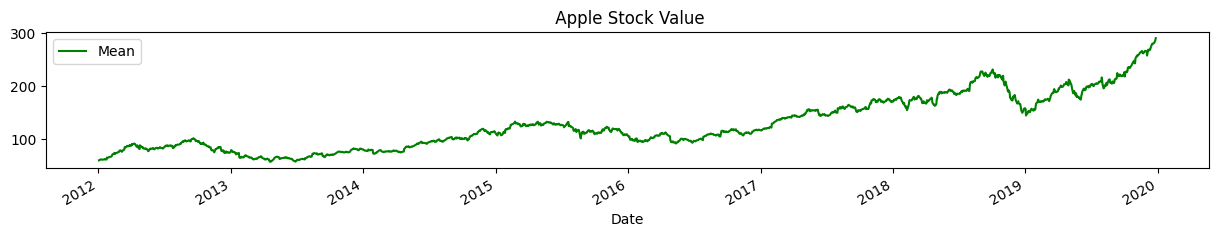

In [12]:
dataset_for_prediction['Mean'].plot(color='green', figsize=(15,2))
plt.legend([  'Mean'])
plt.title(" Apple Stock Value")

Text(0.5, 1.0, ' Apple  Stock Volume')

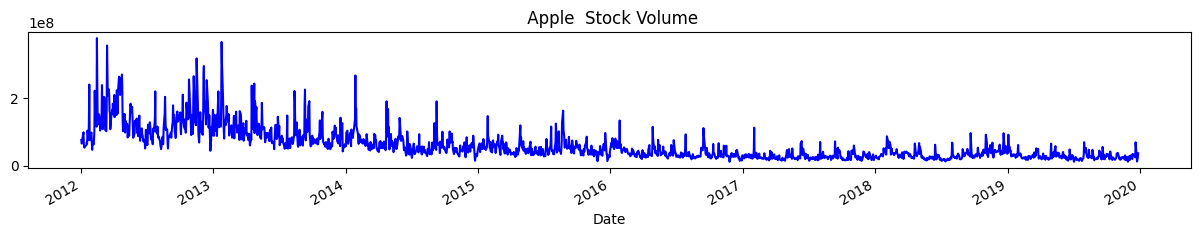

In [13]:
dataset_for_prediction['Volume'].plot(color='blue', figsize=(15,2))
plt.title(" Apple  Stock Volume")

In [14]:
# normalizing input features
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open', 'Close', 'Volume', 'Adj Close', 'Mean']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [15]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [16]:
X= scaled_input

In [18]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Adj Close', 6:'Mean'}, inplace=True)
X= pd.DataFrame(X)
X.index=dataset_for_prediction.index
X

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2012-01-03,0.014647,0.007780,0.012989,0.012631,0.175791,0.007715,0.011186
2012-01-04,0.014819,0.009094,0.013353,0.013979,0.146901,0.008856,0.011933
2012-01-05,0.016896,0.011428,0.016353,0.016780,0.154601,0.011227,0.014140
2012-01-06,0.020910,0.013961,0.019274,0.019447,0.186794,0.013484,0.017408
2012-01-09,0.022216,0.016976,0.022747,0.019038,0.238641,0.013138,0.019575
...,...,...,...,...,...,...,...
2019-12-20,0.958989,0.952213,0.962282,0.955279,0.157825,0.956493,0.955574
2019-12-23,0.966753,0.958967,0.955069,0.974757,0.036370,0.975442,0.962829
2019-12-24,0.977693,0.961669,0.972719,0.975910,0.002075,0.976563,0.969616


In [19]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y

,Stock Price next day
Date,
2012-01-03,0.011933
2012-01-04,0.014140
2012-01-05,0.017408
2012-01-06,0.019575
2012-01-09,0.019089
...,...
2019-12-20,0.962829
2019-12-23,0.969616
2019-12-24,0.984234


In [23]:
train_size=int(len(dataset) *0.80)
test_size = int(len(dataset)) - train_size
print(test_size)

403


In [24]:
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [25]:
test_X.columns

Index(['Low', 'High', 'Open', 'Close', 'Volume', 'Adj Close', 'Mean'], dtype='object')

In [26]:
y_test=y['Stock Price next day'][:train_size].dropna()

In [27]:
type(y_test)

pandas.core.series.Series

In [74]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is  Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [75]:
test_adf(y_test, " Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for  Stock Price


In [76]:
test_adf(y_test.diff(), " Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary  Stock Price


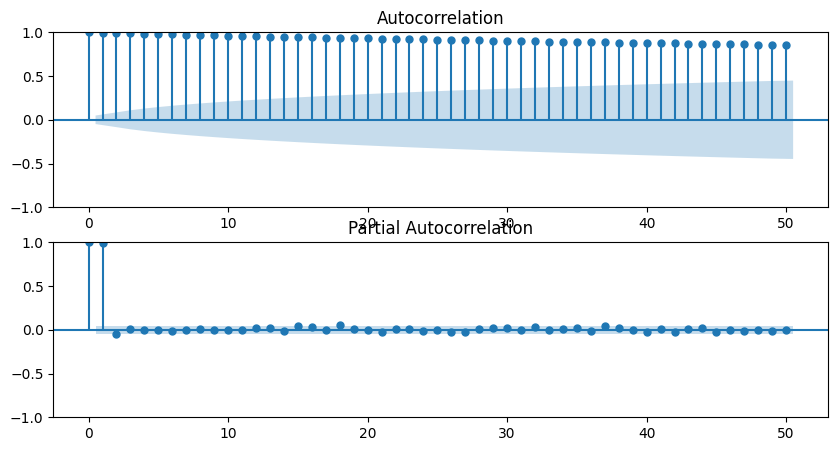

In [31]:
#Correlograms
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [78]:
train_y.shape, train_X.shape

((1608, 1), (1608, 3))

In [32]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
                     exogenous= train_X,
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11834.425, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11784.277, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11831.222, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11835.526, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11781.396, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11834.486, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11832.087, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-11833.954, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.949 seconds


In [33]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1608
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5920.763
Date:                Tue, 05 Sep 2023   AIC                         -11835.526
Time:                        19:38:53   BIC                         -11819.379
Sample:                             0   HQIC                        -11829.531
                               - 1608                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.841      0.066   -2.17e-05       0.001
ma.L1          0.1839      0.017     10.792      0.000       0.151       0.217
sigma2      3.687e-05   6.38e-07     57.827      0.000    3.56e-05    3.81e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2730.31
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
           exog=train_X,
              order=(0,1,1),
              enforce_invertibility=False, enforce_stationarity=False)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
results= model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79067D+00    |proj g|=  5.34698D-01


 This problem is unconstrained.



At iterate    5    f= -3.79079D+00    |proj g|=  3.01275D+00

At iterate   10    f= -3.79120D+00    |proj g|=  1.88758D+00

At iterate   15    f= -3.79273D+00    |proj g|=  6.21693D+00

At iterate   20    f= -3.79304D+00    |proj g|=  8.18616D-02

At iterate   25    f= -3.79312D+00    |proj g|=  2.57507D+00

At iterate   30    f= -3.79936D+00    |proj g|=  2.20912D+01

At iterate   35    f= -3.81911D+00    |proj g|=  2.68410D+00

At iterate   40    f= -3.81969D+00    |proj g|=  3.02669D-01

At iterate   45    f= -3.81984D+00    |proj g|=  1.63307D+00

At iterate   50    f= -3.82386D+00    |proj g|=  5.42558D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
test_X

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2018-05-24,0.562816,0.556197,0.565754,0.565351,0.032511,0.560212,0.559480
2018-05-25,0.568994,0.559616,0.563463,0.567188,0.016702,0.561960,0.564267
2018-05-29,0.565648,0.555817,0.560790,0.564283,0.030540,0.559196,0.560693
2018-05-30,0.565262,0.552651,0.561299,0.562575,0.020069,0.557570,0.558906
2018-05-31,0.562516,0.553622,0.559177,0.559884,0.044146,0.555008,0.558033
...,...,...,...,...,...,...,...
2019-12-20,0.958989,0.952213,0.962282,0.955279,0.157825,0.956493,0.955574
2019-12-23,0.966753,0.958967,0.955069,0.974757,0.036370,0.975442,0.962829
2019-12-24,0.977693,0.961669,0.972719,0.975910,0.002075,0.976563,0.969616


In [37]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 402 entries, 2018-05-24 to 2019-12-27
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Low        402 non-null    float64
 1   High       402 non-null    float64
 2   Open       402 non-null    float64
 3   Close      402 non-null    float64
 4   Volume     402 non-null    float64
 5   Adj Close  402 non-null    float64
 6   Mean       402 non-null    float64
dtypes: float64(7)
memory usage: 25.1 KB


In [38]:
test_X[['Low', 'High', 'Open', 'Close', 'Volume', 'Adj Close', 'Mean']]

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2018-05-24,0.562816,0.556197,0.565754,0.565351,0.032511,0.560212,0.559480
2018-05-25,0.568994,0.559616,0.563463,0.567188,0.016702,0.561960,0.564267
2018-05-29,0.565648,0.555817,0.560790,0.564283,0.030540,0.559196,0.560693
2018-05-30,0.565262,0.552651,0.561299,0.562575,0.020069,0.557570,0.558906
2018-05-31,0.562516,0.553622,0.559177,0.559884,0.044146,0.555008,0.558033
...,...,...,...,...,...,...,...
2019-12-20,0.958989,0.952213,0.962282,0.955279,0.157825,0.956493,0.955574
2019-12-23,0.966753,0.958967,0.955069,0.974757,0.036370,0.975442,0.962829
2019-12-24,0.977693,0.961669,0.972719,0.975910,0.002075,0.976563,0.969616


In [39]:
train_X

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2012-01-03,0.014647,0.007780,0.012989,0.012631,0.175791,0.007715,0.011186
2012-01-04,0.014819,0.009094,0.013353,0.013979,0.146901,0.008856,0.011933
2012-01-05,0.016896,0.011428,0.016353,0.016780,0.154601,0.011227,0.014140
2012-01-06,0.020910,0.013961,0.019274,0.019447,0.186794,0.013484,0.017408
2012-01-09,0.022216,0.016976,0.022747,0.019038,0.238641,0.013138,0.019575
...,...,...,...,...,...,...,...
2018-05-17,0.563460,0.556492,0.562487,0.560396,0.016245,0.555496,0.559948
2018-05-18,0.562473,0.551849,0.559050,0.557492,0.018993,0.552732,0.557118
2018-05-21,0.565819,0.558012,0.562487,0.563130,0.019276,0.558098,0.561884


In [40]:
step_wise=auto_arima(train_y, 
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11834.425, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11784.277, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11831.222, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11835.526, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11781.396, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11834.486, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11832.087, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-11833.954, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.981 seconds


In [41]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1608
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5920.763
Date:                Tue, 05 Sep 2023   AIC                         -11835.526
Time:                        19:39:58   BIC                         -11819.379
Sample:                             0   HQIC                        -11829.531
                               - 1608                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.841      0.066   -2.17e-05       0.001
ma.L1          0.1839      0.017     10.792      0.000       0.151       0.217
sigma2      3.687e-05   6.38e-07     57.827      0.000    3.56e-05    3.81e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2730.31
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
model= SARIMAX(train_y,            
              order=(2,1,0),
              enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()
forecast = results.forecast(steps=2)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.67594D+00    |proj g|=  2.68738D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   2.687D-01  -3.676D+00
  F =  -3.6759429310039460     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g 

In [43]:
a=train_size+test_size-(steps)-train_size
steps

-1

In [44]:
model= SARIMAX(train_y, 
               exog=train_X,            
              order=(0,1,1),
              enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)
print(len(predictions))

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79067D+00    |proj g|=  5.34698D-01

At iterate    5    f= -3.79079D+00    |proj g|=  3.01275D+00

At iterate   10    f= -3.79120D+00    |proj g|=  1.88758D+00

At iterate   15    f= -3.79273D+00    |proj g|=  6.21693D+00

At iterate   20    f= -3.79304D+00    |proj g|=  8.18616D-02

At iterate   25    f= -3.79312D+00    |proj g|=  2.57507D+00

At iterate   30    f= -3.79936D+00    |proj g|=  2.20912D+01

At iterate   35    f= -3.81911D+00    |proj g|=  2.68410D+00

At iterate   40    f= -3.81969D+00    |proj g|=  3.02669D-01

At iterate   45    f= -3.81984D+00    |proj g|=  1.63307D+00

At iterate   50    f= -3.82386D+00    |proj g|=  5.42558D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [45]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [46]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [51]:
forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index=test_X.index
forecast_apple['Actual'] =scaler_output.iloc[train_size:, 0]

In [52]:
forecast_apple

,predicted_mean,Actual
Date,,
2018-05-24,0.562106,0.564267
2018-05-25,0.563985,0.560693
2018-05-29,0.561391,0.558906
2018-05-30,0.559652,0.558033
2018-05-31,0.557211,0.565778
...,...,...
2019-12-20,0.943511,0.962829
2019-12-23,0.963309,0.969616
2019-12-24,0.963021,0.984234


<Axes: xlabel='Date'>

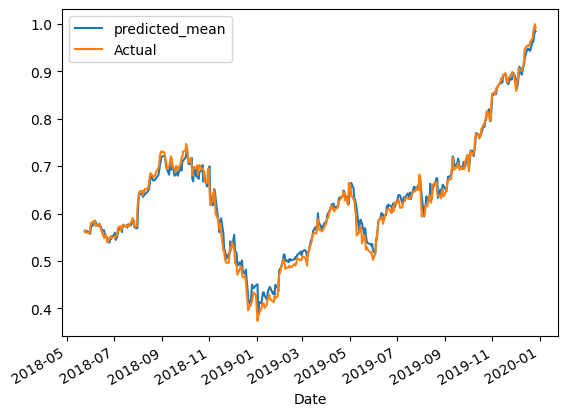

In [53]:
forecast_apple['predicted_mean'].plot(legend=True)
forecast_apple['Actual'].plot(legend=True)

In [54]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

In [55]:
predictions.head()

,predicted_mean,Actual
Date,,
2018-05-24,0.562106,0.564267
2018-05-25,0.563985,0.560693
2018-05-29,0.561391,0.558906
2018-05-30,0.559652,0.558033
2018-05-31,0.557211,0.565778


<Axes: xlabel='Date'>

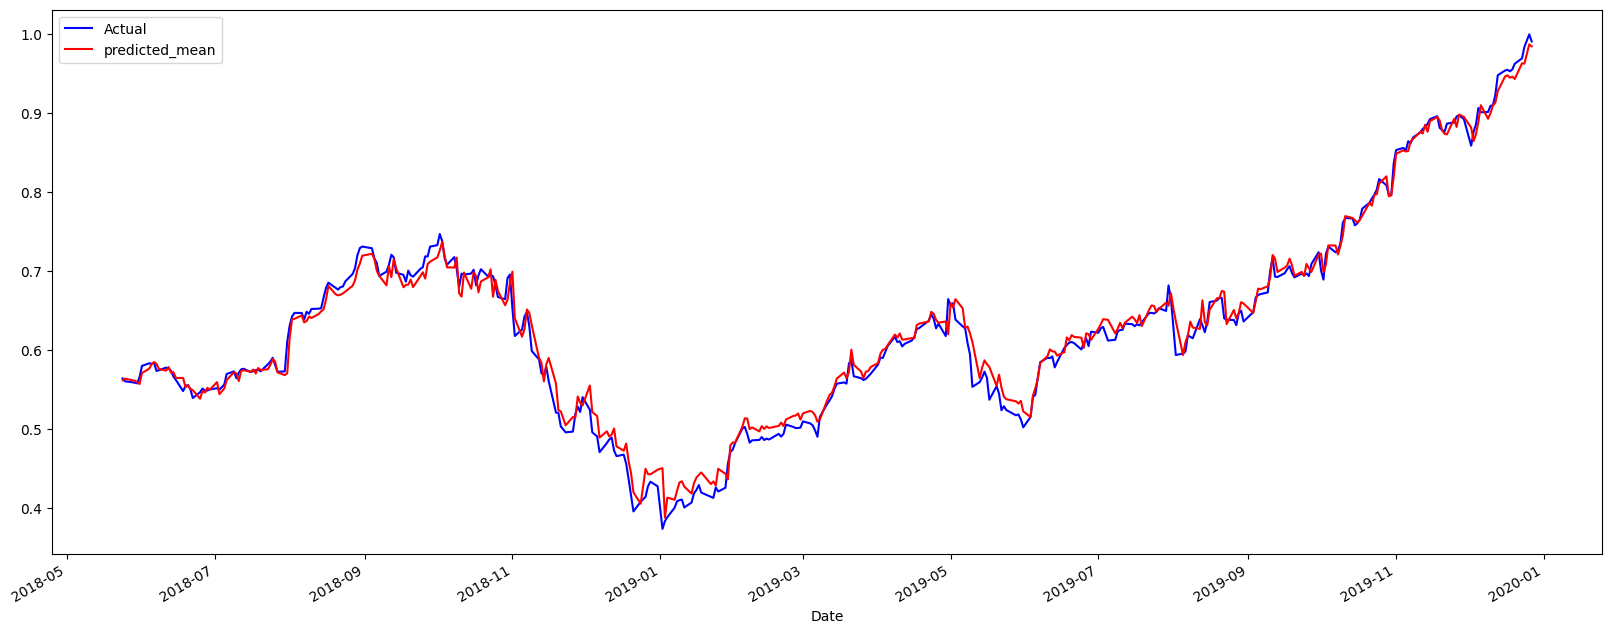

In [56]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['predicted_mean'].plot(legend=True, color='red', figsize=(20,8))

In [58]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['predicted_mean'], predictions['Actual'])
error

0.014198291786070108

In [59]:
X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2012-01-03,0.014647,0.007780,0.012989,0.012631,0.175791,0.007715,0.011186
2012-01-04,0.014819,0.009094,0.013353,0.013979,0.146901,0.008856,0.011933


In [60]:
# invert predictions, scale values back to real index/price range.
testPredict = sc_out.inverse_transform(predictions[['predicted_mean']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

In [73]:
len(testPredict) , len(testActual) 

(402, 402)

<Axes: >

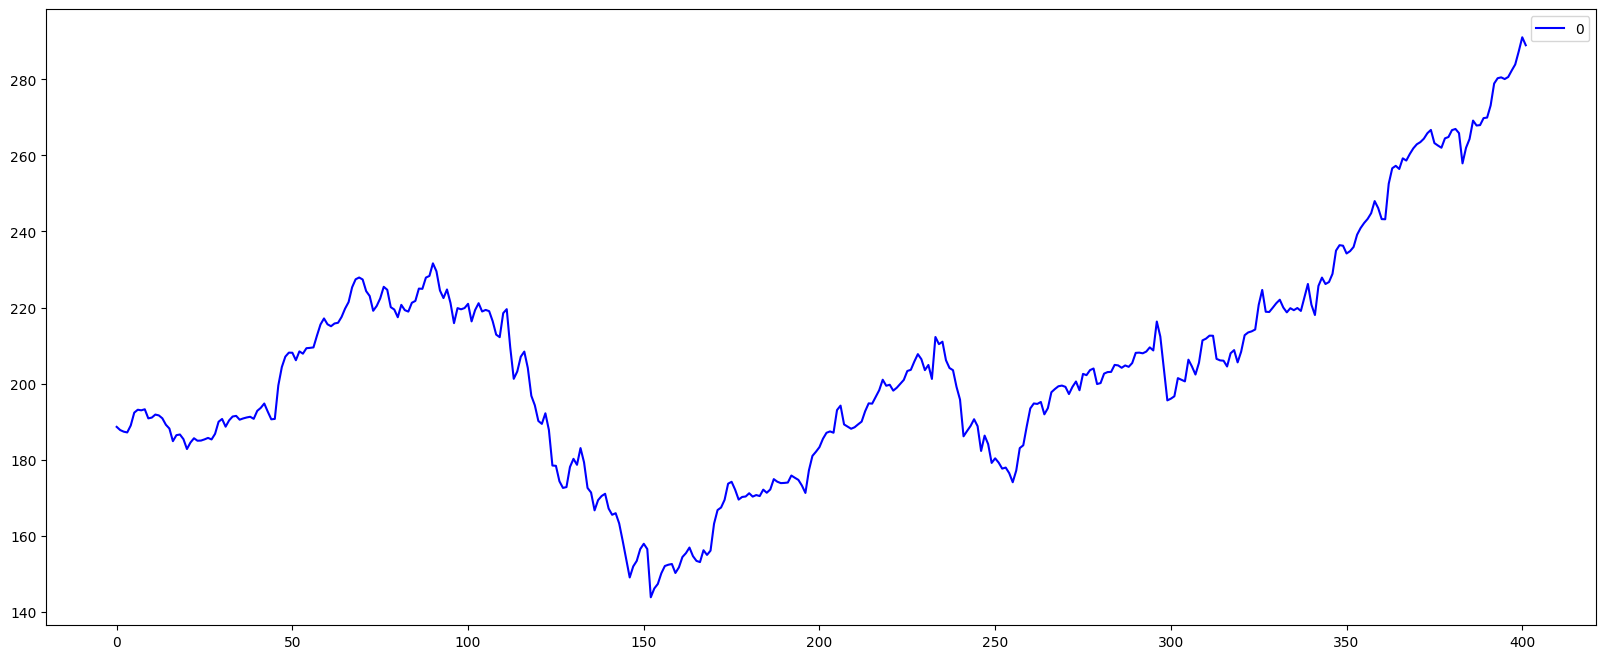

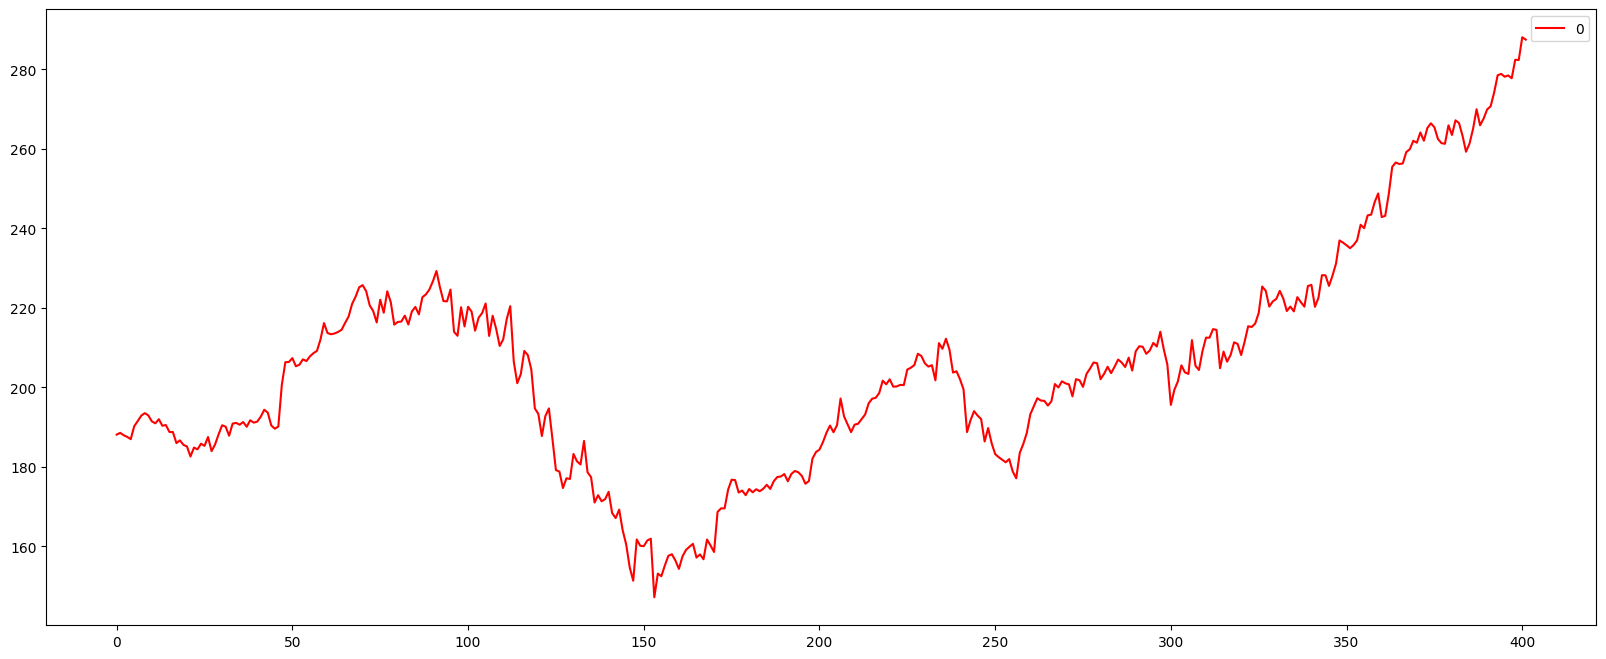

In [71]:
pd.DataFrame(testActual).plot(figsize=(20,8), legend=True, color='blue')
pd.DataFrame(testPredict).plot(legend=True, color='red', figsize=(20,8))